In [1]:
import tensorflow as tf
import numpy as np
import os
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.python.keras.preprocessing import image as kp_image
seed = 42
np.random.seed(seed)

# Trabalho 3 - Autoencoder convencional

Nome: Bruno Rodrigues Silva

Nesse trabalho você deve  criar um autoencoder convencional com camadas convolucionais usando as imagens do conjunto "Anime Faces", que pode ser obtido em https://github.com/bchao1/Anime-Face-Dataset.

Para facilitar o treinamento do autoencoder redimensione as imagens para 64x64x3 pixels.

Após treinar o seu autoencoder realize os seguintes testes:

1) Reconstrução de imagens do conjunto de dados. Reconstrua pelo menos 16 imagens e faça um gráfico das imagens reconstruídas junto com as imagens originais. Além disso, calcule o erro de reconstrução de cada imagem.

2) Criação de imagens novas originais por meio da combinação da representação latente de duas imagens. Nessa etapa crie várias transições entre duas imagens do conjunto de teste, iniciando de uma delas até obter a outra. Faça isso para pelo menos 8 pares de imagens do conjunto de dados.

In [2]:
# buscando as imagens e armazenando
img_size = (64, 64)
imgs = []
for f in tqdm(os.listdir('data/cropped')):
    # algumas imagens vem com tamanho = 0, pra isso foi usado o bloco try abaixo
    try:
        img = Image.open(os.path.join('data/cropped', f))
        resized_img = img.resize(img_size, Image.ANTIALIAS)
        imgs.append(resized_img)
    except Exception as e:
        pass

  0%|          | 0/20000 [00:00<?, ?it/s]

Verificação de alguns exemplos de imagens

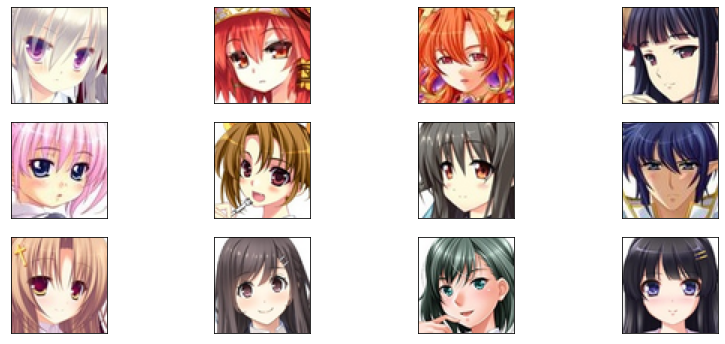

In [4]:
random_imgs = np.random.randint(0, len(imgs), size=(3, 4))
fig, ax = plt.subplots(3, 4, figsize=(14, 6))

for random_col in range(random_imgs.shape[1]):
    for random_row in range(random_imgs.shape[0]):
        ax[random_row, random_col].imshow(imgs[random_imgs[random_row, random_col]])
        ax[random_row, random_col].get_xaxis().set_visible(False)
        ax[random_row, random_col].get_yaxis().set_visible(False)

Convertendo as imagens para np arrays

In [5]:
x_all = []
for img in imgs:
    x_all.append(kp_image.img_to_array(img))
    
del imgs

In [6]:
x_all = np.asarray(x_all)

In [7]:
x_train, x_test = train_test_split(x_all, train_size=0.7, random_state=seed)
x_train = x_train/255.
x_test = x_test/255.
x_train = np.reshape(x_train, (len(x_train), 64, 64, 3))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 3))

Criando e compilando a rede

In [9]:
# Importa classes e funções
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D


input_img = Input(shape=(64, 64, 3))
encoding_dim = 32

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# Add a Dense layer with a L1 activity regularizer



In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        9232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0     

In [11]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                verbose=0,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/autoencoder')])

Epoch 1/100
110/110 [==============================] - 301s 3s/step - loss: 0.5890 - val_loss: 0.5508
Epoch 2/100
110/110 [==============================] - 231s 2s/step - loss: 0.5440 - val_loss: 0.5359
Epoch 3/100
110/110 [==============================] - 218s 2s/step - loss: 0.5332 - val_loss: 0.5296
Epoch 4/100
110/110 [==============================] - 217s 2s/step - loss: 0.5289 - val_loss: 0.5276
Epoch 5/100
110/110 [==============================] - 217s 2s/step - loss: 0.5270 - val_loss: 0.5261
Epoch 6/100
110/110 [==============================] - 215s 2s/step - loss: 0.5253 - val_loss: 0.5237
Epoch 7/100
110/110 [==============================] - 210s 2s/step - loss: 0.5244 - val_loss: 0.5228
Epoch 8/100
110/110 [==============================] - 209s 2s/step - loss: 0.5233 - val_loss: 0.5221
Epoch 9/100
110/110 [==============================] - 208s 2s/step - loss: 0.5224 - val_loss: 0.5217
Epoch 10/100
110/110 [==============================] - 206s 2s/step - loss: 0.521

110/110 [==============================] - 202s 2s/step - loss: 0.5082 - val_loss: 0.5077
Epoch 81/100
110/110 [==============================] - 204s 2s/step - loss: 0.5082 - val_loss: 0.5075
Epoch 82/100
110/110 [==============================] - 203s 2s/step - loss: 0.5081 - val_loss: 0.5073
Epoch 83/100
110/110 [==============================] - 202s 2s/step - loss: 0.5082 - val_loss: 0.5076
Epoch 84/100
110/110 [==============================] - 204s 2s/step - loss: 0.5081 - val_loss: 0.5073
Epoch 85/100
110/110 [==============================] - 201s 2s/step - loss: 0.5080 - val_loss: 0.5071
Epoch 86/100
110/110 [==============================] - 204s 2s/step - loss: 0.5081 - val_loss: 0.5073
Epoch 87/100
110/110 [==============================] - 202s 2s/step - loss: 0.5079 - val_loss: 0.5073
Epoch 88/100
110/110 [==============================] - 202s 2s/step - loss: 0.5080 - val_loss: 0.5071
Epoch 89/100
110/110 [==============================] - 203s 2s/step - loss: 0.5079 - 

In [16]:
autoencoder.save('models/autoencoder')

INFO:tensorflow:Assets written to: models/autoencoder/assets


Para a comparação das imagens, a métrica escolhida foi o Mean Squared Error, onde quanto menor, melhor.

In [38]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    return err

## Exercício 1 - Comparação entre imagens originais e transformadas

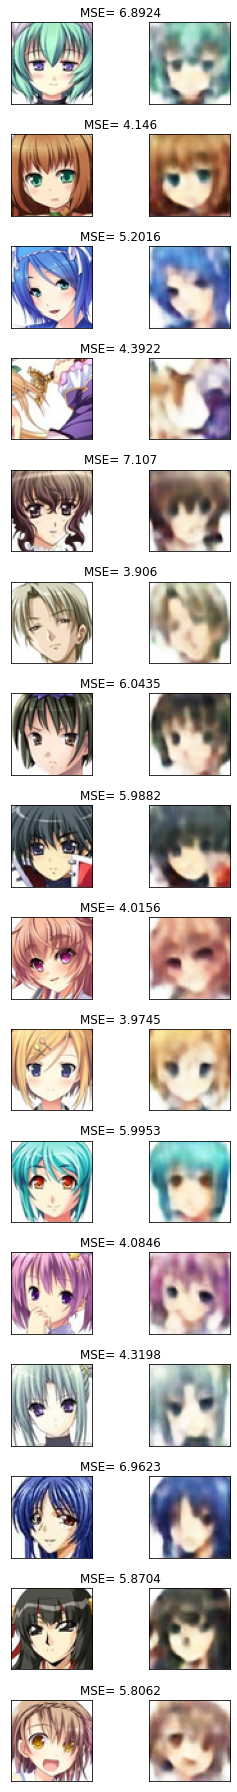

In [74]:
#decoded_imgs = autoencoder.predict(x_test)

random_imgs = np.random.randint(0, len(x_test), size=(16))
fig, ax = plt.subplots(16, 2, figsize=(4, 25))

for random_row in range(random_imgs.shape[0]):
    ax[random_row, 0].imshow(x_test[random_imgs[random_row]].reshape(64,64,3))
    ax[random_row, 1].imshow(decoded_imgs[random_imgs[random_row]].reshape(64,64,3))
    ax[random_row, 0].get_xaxis().set_visible(False)
    ax[random_row, 0].get_yaxis().set_visible(False)
    ax[random_row, 1].get_xaxis().set_visible(False)
    ax[random_row, 1].get_yaxis().set_visible(False)
    ax[random_row, 0].set_title("MSE= {}".format(round(100*mse(x_test[random_imgs[random_row]].reshape(64,64,3), decoded_imgs[random_imgs[random_row]].reshape(64,64,3)), 4)), x=1.35)
fig.tight_layout()

## Exercício 2 - Superposição entre imagens transformadas

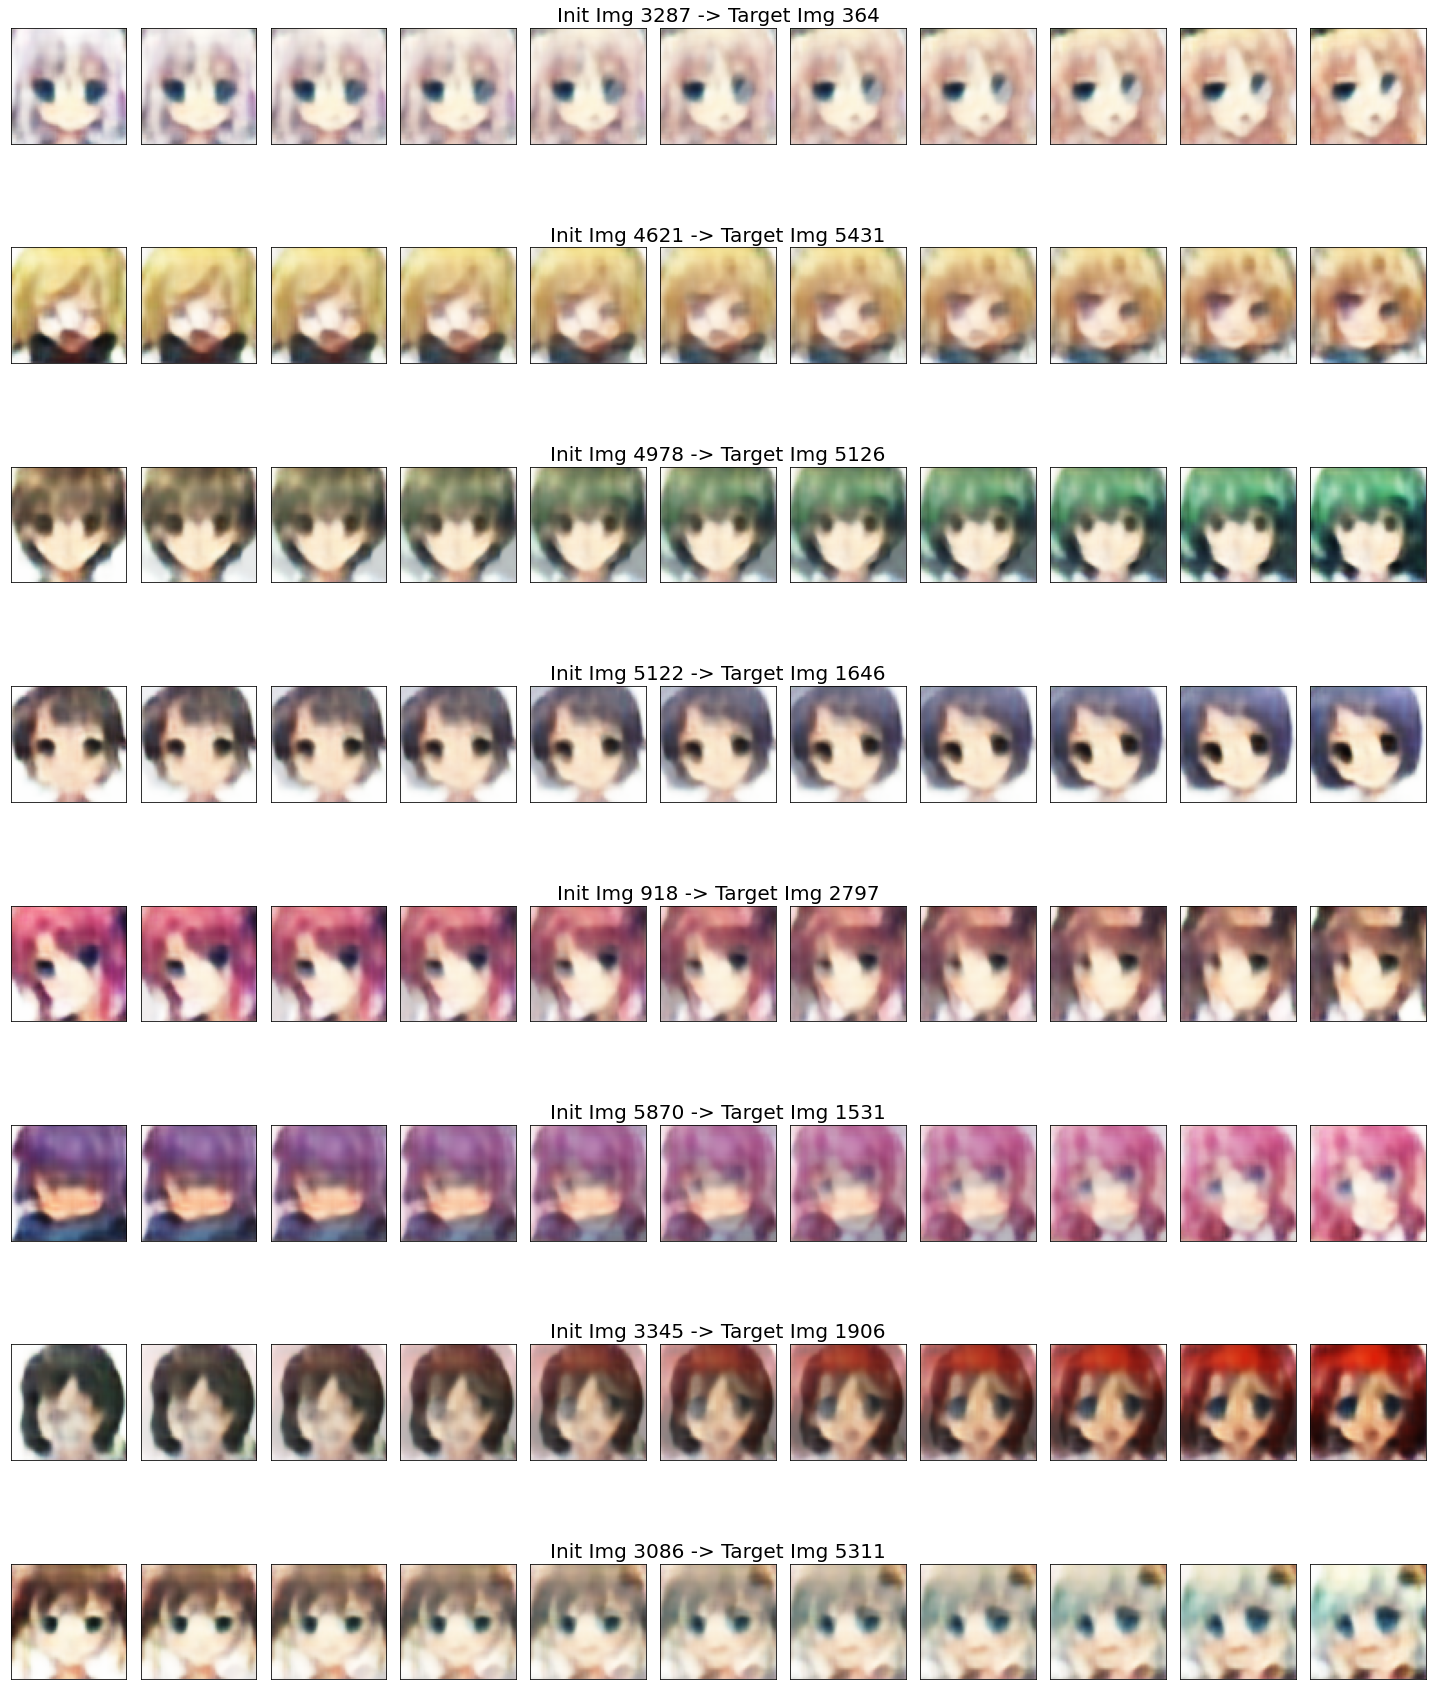

In [130]:
low = 0
high = 1.01
step = 0.1

n = round((high - low) // step)
fig, ax = plt.subplots(8, n+1, figsize=(20,25))

for k in range(8):
    random_img = np.random.randint(0, len(x_test))
    random_target = np.random.randint(0, len(x_test))
    
    for i, value in enumerate(np.arange(low, high, step)):
        ax[k, i].imshow((1-value)*decoded_imgs[random_img].reshape(64,64,3)+(value)*decoded_imgs[random_target].reshape(64,64,3))
        ax[k, i].get_xaxis().set_visible(False)
        ax[k, i].get_yaxis().set_visible(False)
    ax[k, int(n/2)].set_title("Init Img {} -> Target Img {}".format(random_img, random_target), fontsize=20)
fig.tight_layout()

## Exercício 2 Bônus - GIF da trânsição

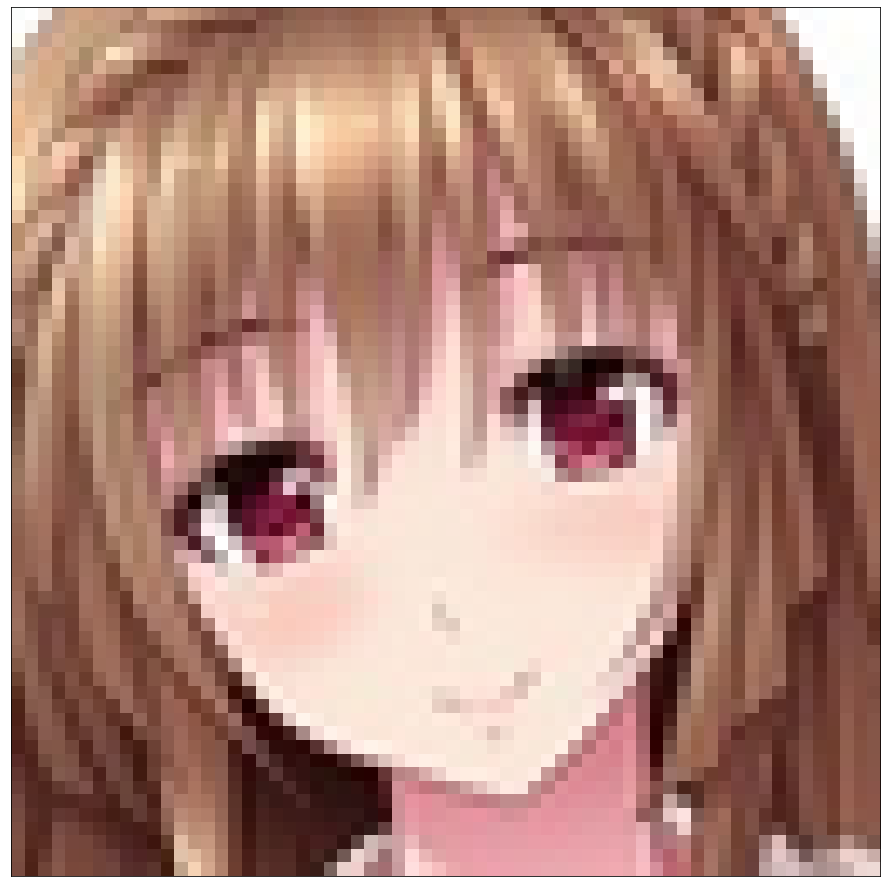

In [144]:
from celluloid import Camera
low = 0
high = 1.01
step = 0.01

n = round((high - low) // step)
fig = plt.figure(figsize=(16, 16))
cam = Camera(fig)

random_img = np.random.randint(0, len(x_test))
random_target = np.random.randint(0, len(x_test))
ax = plt.gca()
for i in range(30):
    plt.imshow(x_test[random_img].reshape(64,64,3))
    cam.snap()
for i, value in enumerate(np.arange(low, high, step)):
    plt.imshow((1-value)*decoded_imgs[random_img].reshape(64,64,3)+(value)*decoded_imgs[random_target].reshape(64,64,3))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    cam.snap()
for i in range(30):
    plt.imshow(x_test[random_target].reshape(64,64,3))
    cam.snap()
anim = cam.animate(interval=70)

anim.save('transition.gif');